#**Text-to-Image using DCGAN**

##**1.Data Preparing**



*   Download the flowers caption data: [link](https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view?resourcekey=0-Av8zFbeDDvNcF1sSjDR32w)
*   Download the flowers image data: [link](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)
*   Download the flowers caption embedding: [link](https://drive.google.com/file/d/0B0ywwgffWnLLMl9uOU91MV80cVU/view?resourcekey=0-vy4hVV-6Hvpw3AiYipoa3g)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q torchfile

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import h5py
import torchfile
from glob import glob

In [ ]:
%cd /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 09/[Exercise]-DCGAN

/content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 09/[Exercise]-DCGAN


In [ ]:
images_path = './data/'
embedding_path = './data/flowers_icml/'
text_path = './data/cvpr2016_flowers/text_c10/'
save_dataset_path = './data/flowers.hdf5'

train_path = './data/flowers_icml/trainclasses.txt'
val_path = './data/flowers_icml/valclasses.txt'
test_path = './data/flowers_icml/testclasses.txt'

In [ ]:
train_classes = open(train_path).read().splitlines()
val_classes = open(val_path).read().splitlines()
test_classes = open(test_path).read().splitlines()

In [ ]:
f = h5py.File(save_dataset_path, 'w')
train = f.create_group('train')
val = f.create_group('val')
test = f.create_group('test')

for _class in sorted(os.listdir(embedding_path)):
    split = ''
    if _class in train_classes:
        split = train
    elif _class in val_classes:
        split = val
    elif _class in test_classes:
        split = test

    data_path = os.path.join(embedding_path, _class)
    txt_path = os.path.join(text_path, _class)
    for example, txt_file in zip(sorted(glob(data_path + "/*.t7")), sorted(glob(txt_path + "/*.txt"))):
        example_data = torchfile.load(example)
        img_path = example_data[b'img'].decode("utf-8")
        embeddings = example_data[b'txt']
        example_name = img_path.split('/')[-1][:-4]

        f = open(txt_file, "r")
        txt = f.readlines()
        f.close()

        img_path = os.path.join(images_path, img_path)
        img = open(img_path, 'rb').read()

        print(example_name, txt)
        txt_choice = np.random.choice(range(10), 5)

        embeddings = embeddings[txt_choice]
        txt = np.array(txt)
        txt = txt[txt_choice]
        dt = h5py.special_dtype(vlen=str)

        for c, e in enumerate(embeddings):
            ex = split.create_group(example_name + '_' + str(c))
            ex.create_dataset('name', data=example_name)
            ex.create_dataset('img', data=np.void(img))
            ex.create_dataset('embeddings', data=e)
            ex.create_dataset('class', data=_class)
            ex.create_dataset('txt', data=txt[c].astype(object), dtype=dt)

        print(example_name, txt[1], _class)

Streaming output truncated to the last 5000 lines.
image_01785 this flower has broad pink petals, yellow and red anther filaments and a pink stamen.
 class_00083
image_01786 ['this bright red flower has an outer row of star-shaped petals and an inner trumpet-shaped row, and also a prominent yellow pistil\n', 'this flower is red and yellow in color, with petals that are wilted in appearance.\n', 'this flower has petals that are red with yellow stigma\n', 'an orange flower with bent petals and a long orange pollen tube.\n', 'this is a flower with red petals and a long red and yellow pistil.\n', 'this flower has large red petals with small yellow stamens and a red stigma\n', 'this flower is red in color, and has petals that are oval shaped and ruffled.\n', 'this flower has petals that are red and has a yellow style\n', 'this flower has bright red veined petals and a long red stamen and yellow anthers.\n', 'this flower has a tall red pistil and bright red petals.\n']
image_01786 this flowe

In [ ]:
dataset = h5py.File('./data/flowers.hdf5', mode='r')

In [ ]:
dataset['train']['image_08189_4'].keys()

<KeysViewHDF5 ['class', 'embeddings', 'img', 'name', 'txt']>

##**2. Dataset**

In [ ]:
import io
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class Text2ImageDataset(Dataset):

    def __init__(self, dataset_path, transform=None, split=0):
        self.dataset_path = dataset_path
        self.transform = transform
        self.dataset = h5py.File(self.dataset_path, mode='r')
        self.split = 'train' if split == 0 else 'val' if split == 1 else 'test'
        self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        length = len(self.dataset[self.split])
        return length

    def __getitem__(self, idx):
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:

            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        return img.transpose(2, 0, 1)

In [ ]:
train_dataset = Text2ImageDataset(save_dataset_path, split=0)
val_dataset = Text2ImageDataset(save_dataset_path, split=1)
test_dataset = Text2ImageDataset(save_dataset_path, split=2)

In [ ]:
next(iter(train_dataset))

{'right_images': tensor([[[-0.0745, -0.2706, -0.3255,  ..., -0.8980, -0.9059, -0.8745],
          [-0.0275, -0.1294, -0.1216,  ..., -0.8980, -0.9137, -0.8980],
          [-0.0980, -0.0353, -0.0118,  ..., -0.8980, -0.9137, -0.8902],
          ...,
          [-0.2235, -0.0980, -0.1216,  ..., -0.6078, -0.5216, -0.4353],
          [-0.1922, -0.1451,  0.2706,  ..., -0.6000, -0.4980, -0.4196],
          [-0.0118,  0.1059,  0.5059,  ..., -0.5843, -0.4980, -0.4510]],
 
         [[-0.1137, -0.2784, -0.2314,  ..., -0.8824, -0.8902, -0.8588],
          [-0.0118, -0.0902, -0.0667,  ..., -0.8824, -0.8980, -0.8824],
          [-0.0275,  0.0667,  0.0824,  ..., -0.8824, -0.8980, -0.8745],
          ...,
          [-0.1843, -0.1059, -0.1216,  ..., -0.7647, -0.7020, -0.6235],
          [-0.1294, -0.1451,  0.1922,  ..., -0.7569, -0.6706, -0.5922],
          [ 0.0667,  0.1059,  0.3569,  ..., -0.7333, -0.6549, -0.6000]],
 
         [[-0.3412, -0.6471, -0.7255,  ..., -0.9843, -0.9922, -0.9608],
          [-

In [ ]:
next(iter(train_dataset))['right_embed'].shape

torch.Size([1024])

In [ ]:
from torch.utils.data import DataLoader

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

##**3.Model**

In [ ]:
import torch
import torch.nn as nn

# The Generator model
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Generator architecture
        model = []
        model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
        model += self._create_layer(512, 256, 4, stride=2, padding=1)
        model += self._create_layer(256, 128, 4, stride=2, padding=1)
        model += self._create_layer(128, 64, 4, stride=2, padding=1)
        model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
        layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
        if output:
            layers.append(nn.Tanh())  # Tanh activation for the output layer
        else:
            layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
        return layers

    def forward(self, noise, text):
        # Apply text embedding to the input text
        text = self.text_embedding(text)
        text = text.view(text.shape[0], text.shape[1], 1, 1)  # Reshape to match the generator input size
        z = torch.cat([text, noise], 1)  # Concatenate text embedding with noise
        return self.model(z)


# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)  # Resize to match the discriminator input size
        out = torch.cat([x, embed_out_resize], 1)  # Concatenate text embedding with the input feature map
        return out


# The Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        self.model = nn.Sequential(
            *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
            *self._create_layer(64, 128, 4, 2, 1),
            *self._create_layer(128, 256, 4, 2, 1),
            *self._create_layer(256, 512, 4, 2, 1)
        )
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)  # Text embedding module
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
        if normalize:
            layers.append(nn.BatchNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x, text):
        x_out = self.model(x)  # Extract features from the input using the discriminator architecture
        out = self.text_embedding(x_out, text)  # Apply text embedding and concatenate with the input features
        out = self.output(out)  # Final discriminator output
        return out.squeeze(), x_out

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
embed_dim = 1024
noise_dim = 100
embed_out_dim = 64
generator = Generator(
    channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim
).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

In [ ]:
discriminator = Discriminator(
    channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim
).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1024, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, mome

##**4.Training**

In [ ]:
# setting up Adam optimizer for Generator and Discriminator
learning_rate = 0.0002
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)

# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [ ]:
len(train_loader)

15

In [ ]:
import time

num_epochs = 20
real_label = 1.
fake_label = 0.
l1_coef = 50
l2_coef = 100

D_losses = []
G_losses = []

for epoch in range(num_epochs):
    epoch_D_loss = []
    epoch_G_loss = []
    batch_time = time.time()

    for idx, batch in enumerate(train_loader):

        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Clear gradients for the discriminator
        optimizer_D.zero_grad()

        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate fake image batch with the generator
        fake_images = generator(noise, embeddings)

        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))

        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))

        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))

        # Compute total discriminator loss
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake

        # Backpropagate the gradients
        d_loss.backward()

        # Update the discriminator
        optimizer_D.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Clear gradients for the generator
        optimizer_G.zero_grad()

        # Generate new random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate new fake images using Generator
        fake_images = generator(noise, embeddings)

        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embeddings)

        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)

        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())

        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2

        # Backpropagate the gradients
        g_loss.backward()

        # Update the generator
        optimizer_G.step()

        epoch_D_loss.append(d_loss.item())
        epoch_G_loss.append(g_loss.item())

    print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, idx+1, len(train_loader),
        d_loss.mean().item(),
        g_loss.mean().item(),
        time.time() - batch_time)
    )
    D_losses.append(sum(epoch_D_loss)/len(epoch_D_loss))
    G_losses.append(sum(epoch_G_loss)/len(epoch_G_loss))

Epoch 1 [15/15] loss_D: 3.3026 loss_G: 39.4520 time: 396.48
Epoch 2 [15/15] loss_D: 2.5140 loss_G: 30.7094 time: 397.95
Epoch 3 [15/15] loss_D: 1.5642 loss_G: 26.8290 time: 384.60
Epoch 4 [15/15] loss_D: 1.7030 loss_G: 25.2369 time: 385.61
Epoch 5 [15/15] loss_D: 1.6755 loss_G: 24.8807 time: 383.98
Epoch 6 [15/15] loss_D: 1.6383 loss_G: 23.4489 time: 381.46
Epoch 7 [15/15] loss_D: 1.5287 loss_G: 24.0318 time: 381.18
Epoch 8 [15/15] loss_D: 1.6304 loss_G: 24.4494 time: 387.65
Epoch 9 [15/15] loss_D: 2.3599 loss_G: 23.6462 time: 387.20
Epoch 10 [15/15] loss_D: 1.7482 loss_G: 23.8646 time: 384.70
Epoch 11 [15/15] loss_D: 1.7162 loss_G: 24.3593 time: 386.72
Epoch 12 [15/15] loss_D: 1.9531 loss_G: 25.3599 time: 378.62
Epoch 13 [15/15] loss_D: 1.5484 loss_G: 25.5233 time: 387.34
Epoch 14 [15/15] loss_D: 1.7076 loss_G: 23.8551 time: 385.40
Epoch 15 [15/15] loss_D: 1.8955 loss_G: 25.3565 time: 383.65
Epoch 16 [15/15] loss_D: 2.0494 loss_G: 23.8388 time: 384.36
Epoch 17 [15/15] loss_D: 1.8887 l

In [ ]:
!mkdir save_model

In [ ]:
model_save_path = './save_model'
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator.pth'))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator.pth'))

In [ ]:
generator.load_state_dict(torch.load(os.path.join(model_save_path, 'generator.pth')))
discriminator.load_state_dict(torch.load(os.path.join(model_save_path,'discriminator.pth')))

<All keys matched successfully>

In [ ]:
generator.eval()

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

In [ ]:
generator

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

##**5.Prediction**

In [ ]:
example = next(iter(test_dataset))

In [ ]:
example

{'right_images': tensor([[[-0.3098, -0.3569, -0.3333,  ..., -0.8667, -0.8667, -0.8824],
          [-0.3255, -0.3333, -0.3647,  ..., -0.8902, -0.8667, -0.8745],
          [-0.3098, -0.3098, -0.3804,  ..., -0.9059, -0.8824, -0.8745],
          ...,
          [-0.3804, -0.6549, -0.8824,  ..., -0.6941, -0.7333, -0.7647],
          [-0.4824, -0.7176, -0.8510,  ..., -0.6392, -0.7020, -0.6941],
          [-0.6549, -0.7255, -0.8275,  ..., -0.6157, -0.6941, -0.6157]],
 
         [[ 0.2392,  0.1922,  0.2314,  ..., -0.7804, -0.8353, -0.8824],
          [ 0.2549,  0.2078,  0.2000,  ..., -0.7882, -0.8353, -0.8745],
          [ 0.2706,  0.2627,  0.1922,  ..., -0.7961, -0.8667, -0.8667],
          ...,
          [ 0.0510, -0.2863, -0.7569,  ..., -0.8039, -0.7490, -0.7176],
          [-0.0588, -0.3647, -0.6941,  ..., -0.8431, -0.8667, -0.8510],
          [-0.2784, -0.4039, -0.6706,  ..., -0.8196, -0.8745, -0.8118]],
 
         [[ 0.3961,  0.2627,  0.2941,  ..., -0.8118, -0.8745, -0.9216],
          [ 

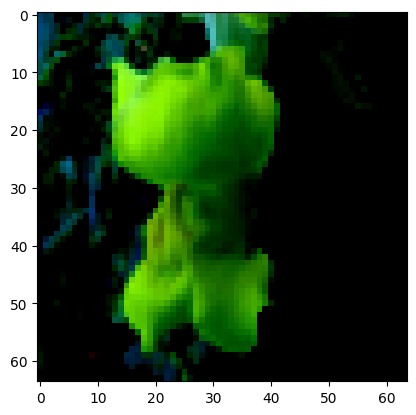

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example['right_images'].permute(1, 2, 0))
plt.show()

In [ ]:
embeddings = example['right_embed'].to(device)
noise = torch.randn(1, noise_dim, 1, 1, device=device)
pred = generator(noise, embeddings.unsqueeze(0))

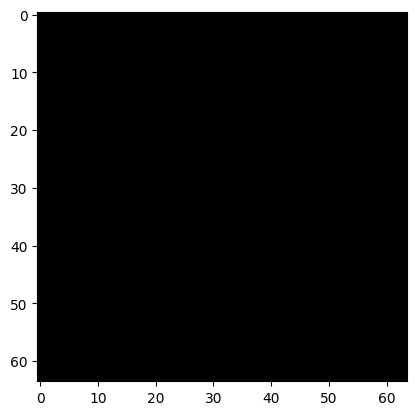

In [ ]:
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0))
plt.show()

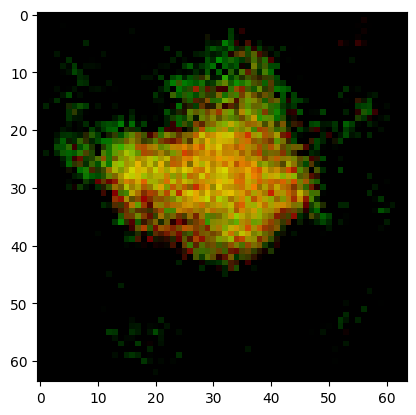

In [ ]:
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0))
plt.show()